In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (7, 3)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 108

In [3]:
import numpy as np

In [273]:
# Time interval between readings
d = 1.0 / 2000.0
# Stride size of the running window
N = 2000
# Have the time-series to be at least 3.0 seconds
K = max(3 * N, round(3.0 / d))
# Double time in seconds
y = np.array([x for x in range(K)], dtype=np.float64) * d + 7000.0
# Clean reference of tic count in microseconds
u = np.array([x for x in range(K)], dtype=np.float64) * 1000000
# Add noise to x, on the orders of 1 millisecond
x = y + 10.0e-3 * (np.random.random(y.shape) - 0.5)

In [276]:
h_x0 = np.ones(x.shape) * np.nan
h_u0 = np.ones(x.shape) * np.nan
h_dx = np.ones(x.shape) * np.nan
t = np.ones(x.shape) * np.nan
b = 1.0 / N
a = 1.0 - b

# Initial values of x0 and u0
u0 = (u[0] - u[1]) * (0.44 * N)     # Rough estimate from the first 2 samples
x0 = x[0]

# dx = 0                             # Have nothing at all
dx = (x[1] - x[0]) / (u[1] - u[0])   # Rough estimate from the first 2 samples
# dx = 1.0e-6 * d                    # If we have a good wisdom

for i in range(1, len(x)):
    if i < N:
        dx_du = (x[i] - x[0]) / (u[i] - u[0])
    else:
        dx_du = (x[i] - x[i - N]) / (u[i] - u[i - N])
    u0 = a * u0 + b * u[i]
    x0 = a * x0 + b * x[i]
    dx = a * dx + b * dx_du
    h_dx[i] = dx
    h_x0[i] = x0
    h_u0[i] = u0
    t[i] = x0 + dx * (u[i] - u0)

Original jitter = 4.15576225062  ms
Smoothed jitter = 0.0424617849794  ms


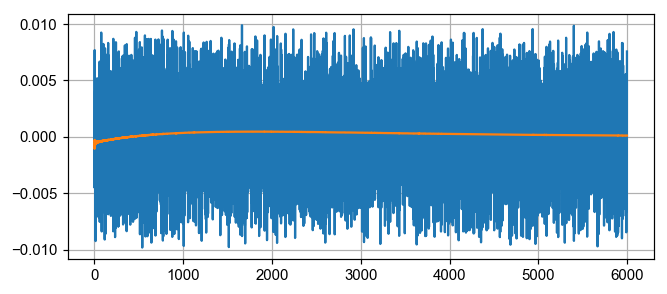

In [277]:
matplotlib.pyplot.plot(np.diff(x) - d)
matplotlib.pyplot.plot(np.diff(t) - d)
# matplotlib.pyplot.ylim(np.array([-1, 1], dtype=np.float32) * 1.0e-3)
# matplotlib.pyplot.xlim(np.array([1999, 2001], dtype=np.float32))
matplotlib.pyplot.grid()
print('Original jitter =', np.std(np.diff(x[-N:])) * 1.0e3, ' ms')
print('Smoothed jitter =', np.std(np.diff(t[-N:])) * 1.0e3, ' ms')

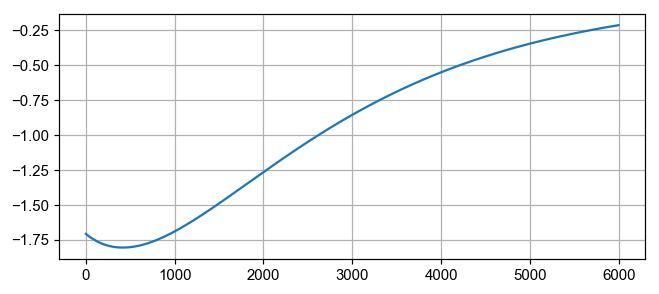

In [278]:
matplotlib.pyplot.plot(t - y)
matplotlib.pyplot.grid()

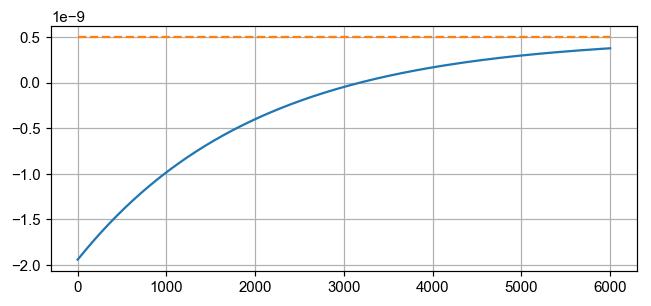

In [279]:
matplotlib.pyplot.plot(h_dx)
matplotlib.pyplot.plot([0, len(x)], np.array([1.0, 1.0]) * 1.0e-6 * d, '--')
matplotlib.pyplot.grid()

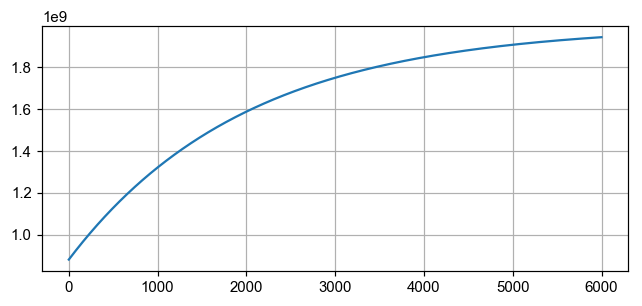

In [280]:
matplotlib.pyplot.plot(u - h_u0)
matplotlib.pyplot.grid()

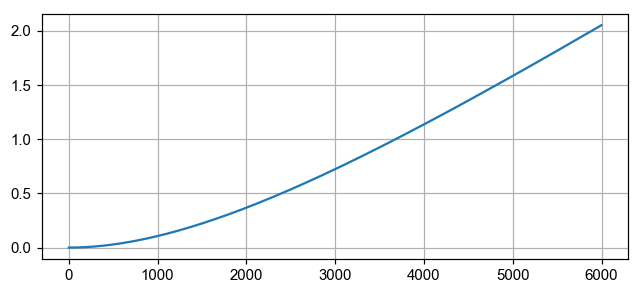

In [281]:
matplotlib.pyplot.plot(h_x0 - 7000.0, '-')
matplotlib.pyplot.grid()
# matplotlib.pyplot.ylim([-0.002, 0.008])
# matplotlib.pyplot.xlim(np.array([N - 4, N + 10], dtype=np.float32))